<a href="https://colab.research.google.com/github/matsu641/APS360/blob/main/Lab4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1w4i-CW7r8PUIDNV8KAydGb2yRttvrhHo#scrollTo=z3p8N43E1ppt

In [46]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [47]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [48]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/tmp/ipython-input-1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [49]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [50]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [51]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [52]:
np.sum(subdf["caploss"])

np.int64(2842700)

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [53]:
# Part (a) Continuous Features
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]

# Report min, max, average for each continuous feature
for col in contcols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean():.2f}")

# Normalize each continuous feature to range [0, 1]
for col in contcols:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)

age: min=17, max=90, mean=38.58
yredu: min=1, max=16, mean=10.08
capgain: min=0, max=99999, mean=1077.65
caploss: min=0, max=4356, mean=87.30
workhr: min=1, max=99, mean=40.44


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [54]:
# Part (b) Categorical Features
total_records = len(df)
male_count = sum(df["sex"] == " Male")
female_count = sum(df["sex"] == " Female")

male_percentage = (male_count / total_records) * 100
female_percentage = (female_count / total_records) * 100

print(f"Male percentage: {male_percentage:.2f}%")
print(f"Female percentage: {female_percentage:.2f}%")


Male percentage: 66.92%
Female percentage: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [55]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [56]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [57]:
# Part (c) Missing values analysis
total_original_records = len(df)
records_with_missing = len(df_with_missing)
records_without_missing = len(df_not_missing)
percentage_removed = (records_with_missing / total_original_records) * 100

print(f"Records with missing features: {records_with_missing}")
print(f"Percentage of records removed: {percentage_removed:.2f}%")

Records with missing features: 1843
Percentage of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [58]:
# Part (d) One-Hot Encoding - possible values of "work"
work_values = set(df_not_missing["work"])
print("Possible values of 'work' feature:")
for value in sorted(work_values):
    print(f"'{value}'")

Possible values of 'work' feature:
' Federal-gov'
' Local-gov'
' Private'
' Self-emp-inc'
' Self-emp-not-inc'
' State-gov'
' Without-pay'


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [59]:
data = pd.get_dummies(df_not_missing)

In [60]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [61]:
# Part (e) One-Hot Encoding - number of columns
num_columns = data.shape[1]
print(f"Total columns: {num_columns}\n")

Total columns: 57



In [91]:
# Check the actual column names of the dataframe
print("=== All Column Names in DataFrame 'data' ===")
print(f"Total columns: {len(data.columns)}")
print()

print("Continuous features:")
for i, col in enumerate(data.columns[:5]):  # First 5 columns are continuous
    print(f"  {i+1}. {col}")
print()
print("Categorical features (one-hot encoded):")
# Group by feature type and display in compact format
feature_groups = {}
categorical_start = 5

for col in data.columns[categorical_start:]:
    if '_' in col:
        feature_name = col.split('_')[0]
        value = col.split('_', 1)[1]
        if feature_name not in feature_groups:
            feature_groups[feature_name] = []
        feature_groups[feature_name].append(value)


for feature_name, values in feature_groups.items():
    print(f"  {feature_name}: ({', '.join(values)})")
print()

=== All Column Names in DataFrame 'data' ===
Total columns: 57

Continuous features:
  1. age
  2. yredu
  3. capgain
  4. caploss
  5. workhr

Categorical features (one-hot encoded):
  work: ( Federal-gov,  Local-gov,  Private,  Self-emp-inc,  Self-emp-not-inc,  State-gov,  Without-pay)
  marriage: ( Divorced,  Married-AF-spouse,  Married-civ-spouse,  Married-spouse-absent,  Never-married,  Separated,  Widowed)
  occupation: ( Adm-clerical,  Armed-Forces,  Craft-repair,  Exec-managerial,  Farming-fishing,  Handlers-cleaners,  Machine-op-inspct,  Other-service,  Priv-house-serv,  Prof-specialty,  Protective-serv,  Sales,  Tech-support,  Transport-moving)
  edu: ( 10th,  11th,  12th,  1st-4th,  5th-6th,  7th-8th,  9th,  Assoc-acdm,  Assoc-voc,  Bachelors,  Doctorate,  HS-grad,  Masters,  Preschool,  Prof-school,  Some-college)
  relationship: ( Husband,  Not-in-family,  Other-relative,  Own-child,  Unmarried,  Wife)
  sex: ( Female,  Male)



In [ ]:
"""
This number comes from:
- 5 continuous features (age, yredu, capgain, caploss, workhr) that were normalized to [0,1] range
- 52 one-hot encoded categorical features created from 6 original categorical columns:
  • work: 7 columns
  • marriage: 7 columns
  • occupation: 14 columns
  • edu: 16 columns
  • relationship: 6 columns
  • sex: 2 columns
- Total: 5 continuous + 52 categorical = 57 columns
"""

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [63]:
datanp = data.values.astype(np.float32)

In [64]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    max_index = np.argmax(onehot)
    return cat_values[feature][max_index]

In [65]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [66]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# Part (g) Train/Test Split
n_total = len(datanp)
indices = np.random.permutation(n_total)

train_size = int(0.7 * n_total)
valid_size = int(0.15 * n_total)
test_size = n_total - train_size - valid_size

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]

data_train = datanp[train_indices]
data_valid = datanp[valid_indices]
data_test = datanp[test_indices]

print(f"Training set size: {len(data_train)}")
print(f"Validation set size: {len(data_valid)}")
print(f"Test set size: {len(data_test)}")

Training set size: 21502
Validation set size: 4607
Test set size: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [67]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [68]:
"""
The sigmoid activation function is used in the last step of the decoder because:
1. All input features in the 'data' dataframe are normalized to the range [0, 1]
2. The continuous features were min-max normalized to [0, 1]
3. The one-hot encoded categorical features naturally have values of 0 or 1
4. The sigmoid function ensures that all output values are in the range (0, 1), matching the input data range
5. This allows the autoencoder to reconstruct data in the same value range as the input
"""

"\nThe sigmoid activation function is used in the last step of the decoder because:\n1. All input features in the 'data' dataframe are normalized to the range [0, 1]\n2. The continuous features were min-max normalized to [0, 1]\n3. The one-hot encoded categorical features naturally have values of 0 or 1\n4. The sigmoid function ensures that all output values are in the range (0, 1), matching the input data range\n5. This allows the autoencoder to reconstruct data in the same value range as the input\n"

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [77]:
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        batch_count = 0

        for batch in train_loader:
            data = batch[0]  # Extract tensor from tuple returned by DataLoader
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_train_loss / batch_count
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_valid_loss = 0
        batch_count = 0

        with torch.no_grad():
            for batch in valid_loader:
                data = batch[0]  # Extract tensor from tuple returned by DataLoader
                datam = zero_out_random_feature(data.clone())
                recon = model(datam)
                loss = criterion(recon, data)
                epoch_valid_loss += loss.item()
                batch_count += 1

        avg_valid_loss = epoch_valid_loss / batch_count
        valid_losses.append(avg_valid_loss)

        # Calculate accuracies every 5 epochs
        if (epoch + 1) % 5 == 0:
            # Create new data loaders that return tensors directly, not tuples
            train_simple_loader = torch.utils.data.DataLoader(torch.tensor(data_train), batch_size=256, shuffle=False)
            valid_simple_loader = torch.utils.data.DataLoader(torch.tensor(data_valid), batch_size=256, shuffle=False)

            train_acc = get_accuracy(model, train_simple_loader)
            valid_acc = get_accuracy(model, valid_simple_loader)
            train_accuracies.append(train_acc)
            valid_accuracies.append(valid_acc)
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}')

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    epochs_acc = range(4, num_epochs, 5)
    plt.plot(epochs_acc, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_acc, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, valid_losses, train_accuracies, valid_accuracies

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [78]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 5: Train Loss: 0.0507, Valid Loss: 0.0476, Train Acc: 0.5760, Valid Acc: 0.5724
Epoch 10: Train Loss: 0.0335, Valid Loss: 0.0330, Train Acc: 0.5969, Valid Acc: 0.5928
Epoch 15: Train Loss: 0.0285, Valid Loss: 0.0278, Train Acc: 0.6095, Valid Acc: 0.6038
Epoch 20: Train Loss: 0.0253, Valid Loss: 0.0250, Train Acc: 0.6043, Valid Acc: 0.6005


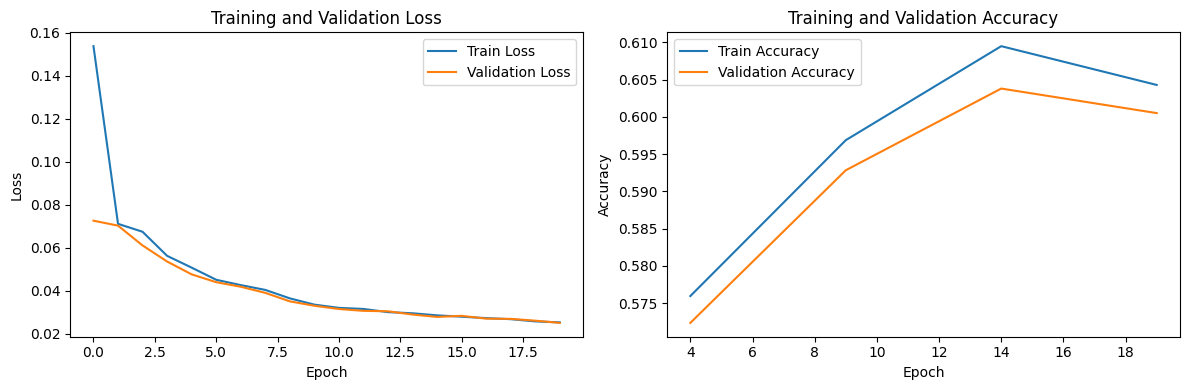

In [79]:
# Part 3(c) - Training with initial hyperparameters
train_dataset = torch.utils.data.TensorDataset(torch.tensor(data_train))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(data_valid))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(data_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

model = AutoEncoder()
train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

Training Model 2 (Higher Learning Rate):
Epoch 5: Train Loss: 0.0271, Valid Loss: 0.0256, Train Acc: 0.6019, Valid Acc: 0.5991
Epoch 10: Train Loss: 0.0220, Valid Loss: 0.0220, Train Acc: 0.6158, Valid Acc: 0.6094
Epoch 15: Train Loss: 0.0204, Valid Loss: 0.0201, Train Acc: 0.6269, Valid Acc: 0.6230
Epoch 20: Train Loss: 0.0182, Valid Loss: 0.0193, Train Acc: 0.6207, Valid Acc: 0.6168


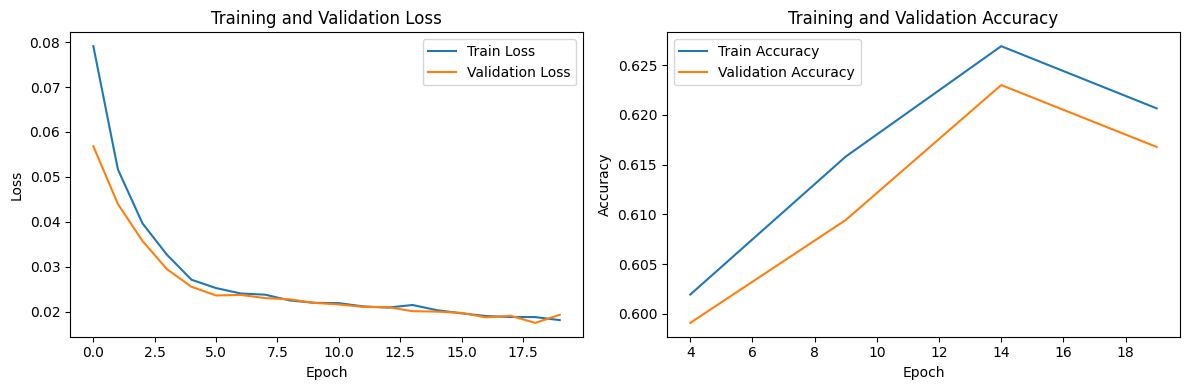

Training Model 3 (Deeper Network):
Epoch 5: Train Loss: 0.0483, Valid Loss: 0.0462, Train Acc: 0.5809, Valid Acc: 0.5809
Epoch 10: Train Loss: 0.0368, Valid Loss: 0.0365, Train Acc: 0.5901, Valid Acc: 0.5898
Epoch 15: Train Loss: 0.0328, Valid Loss: 0.0320, Train Acc: 0.5957, Valid Acc: 0.5932
Epoch 20: Train Loss: 0.0288, Valid Loss: 0.0277, Train Acc: 0.6066, Valid Acc: 0.6034


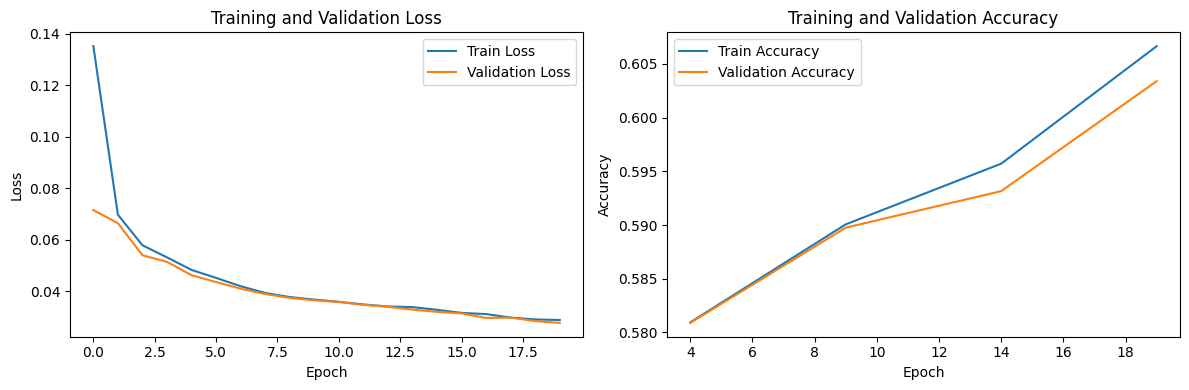

Training Model 4 (Different Architecture, Smaller Batch):
Epoch 5: Train Loss: 0.0312, Valid Loss: 0.0303, Train Acc: 0.6057, Valid Acc: 0.6022
Epoch 10: Train Loss: 0.0209, Valid Loss: 0.0199, Train Acc: 0.6154, Valid Acc: 0.6112
Epoch 15: Train Loss: 0.0156, Valid Loss: 0.0161, Train Acc: 0.6251, Valid Acc: 0.6208
Epoch 20: Train Loss: 0.0143, Valid Loss: 0.0149, Train Acc: 0.6402, Valid Acc: 0.6357
Epoch 25: Train Loss: 0.0131, Valid Loss: 0.0125, Train Acc: 0.6410, Valid Acc: 0.6378
Epoch 30: Train Loss: 0.0123, Valid Loss: 0.0121, Train Acc: 0.6505, Valid Acc: 0.6455


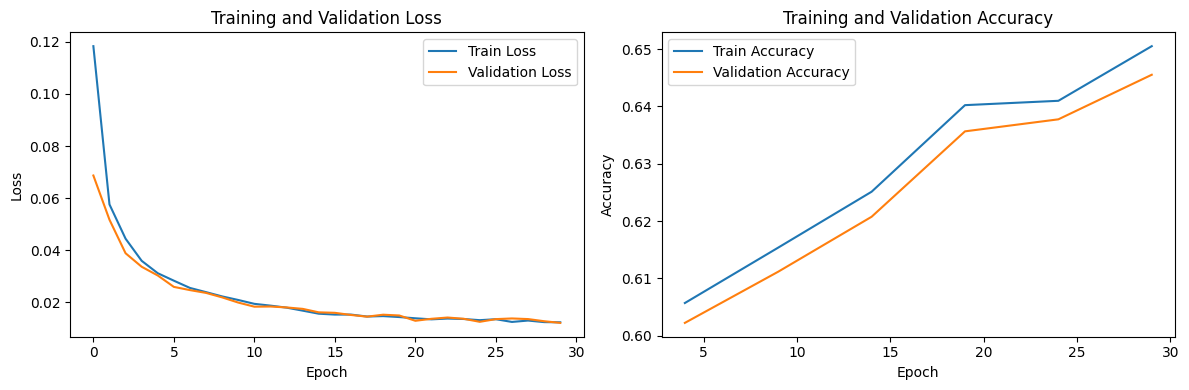

([0.11835444319461073,
  0.05758750671520829,
  0.04441971101221584,
  0.035919452097178214,
  0.031154597355496316,
  0.028288681303993576,
  0.02550217349614416,
  0.023884294898293558,
  0.022248104037273498,
  0.020874663089801158,
  0.019394384791320635,
  0.0187090732645066,
  0.017938203034212903,
  0.01678127778272721,
  0.015607968588093562,
  0.015270258654795942,
  0.015271093740704515,
  0.014520454991032324,
  0.014687733336662253,
  0.014320489861780689,
  0.013845365250571853,
  0.013438606801043664,
  0.013747042427504701,
  0.013574112586433157,
  0.013123889270770763,
  0.013493507889853347,
  0.012445616630083393,
  0.012976579387517026,
  0.012374658622623732,
  0.012305344399508266],
 [0.06868012021813127,
  0.05170164340072208,
  0.0388251074279348,
  0.03363665146753192,
  0.03028648491534922,
  0.02590507807003127,
  0.024671736276812024,
  0.02359494861836235,
  0.021870764800243907,
  0.019882450889175136,
  0.018303801512552634,
  0.018370138610609703,
  0.01

In [80]:
# Part 3(d) - Hyperparameter tuning
"""
Hyperparameter tuning approach:

1. Model 1 (Baseline): Learning rate 1e-3, batch size 256, encoder dims [57->32->16], epochs 20
   - This is our baseline model from Part 3(c)

2. Model 2 (Higher Learning Rate): Learning rate 1e-2, batch size 256, encoder dims [57->32->16], epochs 20
   - Testing if faster learning improves convergence

3. Model 3 (Deeper Network): Learning rate 1e-3, batch size 256, encoder dims [57->64->32->16], epochs 20
   - Testing if more capacity improves performance

4. Model 4 (Different Architecture): Learning rate 1e-3, batch size 128, encoder dims [57->40->20], epochs 30
   - Testing smaller batch size and different bottleneck size with more epochs

The thought process was to systematically vary one hyperparameter at a time to understand their individual effects,
then combine the best settings. Learning rate affects convergence speed and stability, network depth affects capacity,
batch size affects gradient noise, and training epochs affect convergence.
"""

# Model 2: Higher learning rate
model2 = AutoEncoder()
print("Training Model 2 (Higher Learning Rate):")
train(model2, train_loader, valid_loader, num_epochs=20, learning_rate=1e-2)

# Model 3: Deeper network
class DeeperAutoEncoder(nn.Module):
    def __init__(self):
        super(DeeperAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 57),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model3 = DeeperAutoEncoder()
print("Training Model 3 (Deeper Network):")
train(model3, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3)

# Model 4: Different architecture with smaller batch size
class AlternativeAutoEncoder(nn.Module):
    def __init__(self):
        super(AlternativeAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

train_loader_small = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader_small = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)

model4 = AlternativeAutoEncoder()
print("Training Model 4 (Different Architecture, Smaller Batch):")
train(model4, train_loader_small, valid_loader_small, num_epochs=30, learning_rate=1e-3)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [85]:
test_simple_loader = torch.utils.data.DataLoader(torch.tensor(data_test), batch_size=256, shuffle=False)

# Test all trained models
models = [model, model2, model3, model4]
model_names = [
    "Model 1 (Baseline - Part 3c)",
    "Model 2 (Higher Learning Rate)",
    "Model 3 (Deeper Network)",
    "Model 4 (Alternative Architecture)"
]

print("=== Test Accuracy Comparison for All Models ===")
test_accuracies = []
for i, (m, name) in enumerate(zip(models, model_names)):
    acc = get_accuracy(m, test_simple_loader)
    test_accuracies.append(acc)
    print(f"{name}: {acc:.4f} ({acc*100:.2f}%)")

# Find the best model
best_idx = test_accuracies.index(max(test_accuracies))
best_model = models[best_idx]
best_accuracy = test_accuracies[best_idx]

print(f"\nBest performing model is {model_names[best_idx]}")
print(f"Best test accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

print()

=== Test Accuracy Comparison for All Models ===
Model 1 (Baseline - Part 3c): 0.6014 (60.14%)
Model 2 (Higher Learning Rate): 0.6170 (61.70%)
Model 3 (Deeper Network): 0.6015 (60.15%)
Model 4 (Alternative Architecture): 0.6462 (64.62%)

Best performing model is Model 4 (Alternative Architecture)
Best test accuracy: 0.6462 (64.62%)



### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [86]:
# Part 4(b) - Baseline model accuracy
def get_most_common_values(data_array, catcols, cat_index, cat_values):
    most_common = {}
    for feature in catcols:
        start_idx = cat_index[feature]
        end_idx = start_idx + len(cat_values[feature])
        feature_data = data_array[:, start_idx:end_idx]

        value_counts = np.sum(feature_data, axis=0)
        most_common_idx = np.argmax(value_counts)
        most_common[feature] = cat_values[feature][most_common_idx]

    return most_common

def get_baseline_accuracy(test_data, catcols, cat_index, cat_values, most_common_values):
    total = 0
    correct = 0

    for feature in catcols:
        for record in test_data:
            predicted_value = most_common_values[feature]
            actual_value = get_feature(record, feature)

            if predicted_value == actual_value:
                correct += 1
            total += 1

    return correct / total

most_common_values = get_most_common_values(data_train, catcols, cat_index, cat_values)
print("Most common values in training set:")
for feature, value in most_common_values.items():
    print(f"{feature}: {value}")

baseline_accuracy = get_baseline_accuracy(data_test, catcols, cat_index, cat_values, most_common_values)
print(f"\nBaseline Test Accuracy: {baseline_accuracy:.4f}")

Most common values in training set:
work: Private
marriage: Married-civ-spouse
occupation: Prof-specialty
edu: HS-grad
relationship: Husband
sex: Male

Baseline Test Accuracy: 0.4568


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
"""
The neural network models significantly outperform the baseline model. The best performing model
(Model 4 - Alternative Architecture) achieves 64.62% accuracy compared to the baseline's 45.68%,
representing an improvement of 18.94 percentage points. This substantial difference indicates that
the autoencoder is learning meaningful patterns beyond simple statistical frequency, effectively
capturing complex relationships between features for data imputation.
"""

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [88]:
# Part 4(d) - Analysis of first test item
first_test_record = data_test[0]
print("First test record features:")

continuous_features = ["age", "yredu", "capgain", "caploss", "workhr"]
for i, feature in enumerate(continuous_features):
    print(f"{feature}: {first_test_record[i]:.3f}")

print("\nCategorical features:")
categorical_features = get_features(first_test_record)
for feature, value in categorical_features.items():
    print(f"{feature}: {value}")

First test record features:
age: 0.000
yredu: 0.400
capgain: 0.000
caploss: 0.000
workhr: 0.153

Categorical features:
work: Private
marriage: Never-married
occupation: Transport-moving
edu: 11th
relationship: Own-child
sex: Female


In [ ]:
"""
Key indicators suggesting lower education:
- Very young age (0.000 - youngest in dataset) indicates likely still in school
- Relationship status "Own-child" confirms this is a dependent child
- Never-married status consistent with young age
- Transport-moving occupation suggests manual/blue-collar work
- Lower work hours (0.153) typical for part-time or entry-level positions
- No capital gains/losses suggests limited financial assets

The combination of being a young, unmarried female child working in transport with limited hours
strongly suggests someone who hasn't completed high school yet. A human might reasonably guess
an education level around high school (9th-12th grade range), making "11th" a plausible prediction.

However, the exact grade level would be very difficult to determine precisely
without additional context, as the relationships between these demographic factors and specific
education levels involve subtle patterns that require statistical analysis rather than intuition.
"""

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [89]:
# Part 4(e) - Model's prediction for first test item
model.eval()
with torch.no_grad():
    first_test_tensor = torch.tensor(first_test_record).unsqueeze(0)

    # Zero out education feature
    first_test_missing_edu = zero_out_feature(first_test_tensor.clone(), "edu")

    # Get model prediction
    prediction = model(first_test_missing_edu)
    prediction_np = prediction.squeeze().numpy()

    # Get predicted education value
    predicted_education = get_feature(prediction_np, "edu")
    actual_education = get_feature(first_test_record, "edu")

    print(f"Actual education level: {actual_education}")
    print(f"Model's predicted education level: {predicted_education}")
    print(f"Prediction correct: {predicted_education == actual_education}")

Actual education level: 11th
Model's predicted education level: HS-grad
Prediction correct: False


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [90]:
# Part 4(f) - Baseline model's prediction for first test item
baseline_education_prediction = most_common_values["edu"]
actual_education = get_feature(first_test_record, "edu")

print(f"Actual education level: {actual_education}")
print(f"Baseline model's predicted education level: {baseline_education_prediction}")
print(f"Baseline prediction correct: {baseline_education_prediction == actual_education}")

Actual education level: 11th
Baseline model's predicted education level: HS-grad
Baseline prediction correct: False
